<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/geolocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geolocation prediction of Greek proverbs

* Using a collection of proverbs from the [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) of the Academy of Athens
* Using language modelling and text classification to geolocate proverbs whose information is not known.
---


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
balanced_corpus = pd.read_csv("https://raw.githubusercontent.com/ipavlopoulos/paremia/main/input/balanced_corpus.csv")

In [3]:
train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=2023)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)

## Authorship analysis


In [4]:
%%capture
!git clone https://github.com/ipavlopoulos/lm
from lm.markov.models import LM

* Training one language model per area, by sampling proverbs of that area

In [13]:
# building the local language models
loc_name = {'Ρούμελη':'Roumeli', 'Κοζάνη':'Kozani', 'Κως':'Kos', 'Αδριανούπολη':'Adrian.', 'Νάουσα':'Naousa', 'Σέρρες':'Serres', 'Σίφνος': 'Sifnos', 'Ήπειρος':'Epirus', 'Αιτωλία':'Etolia', 'Αμοργός':'Amorgos', 'Ανατολική Θράκη': 'East Thrace',
            'Αρκαδία':'Arcadia', 'Αχαΐα':'Achaia', 'Επτάνησος':'Eptanisos', 'Εύβοια':'Eyvoia', 'Θεσπρωτία':'Thesprotia', 
             'Θράκη': 'Thrace', 'Ιωάννινα':'Ioannina', 'Κάρπαθος':'Karpathos', 'Κεφαλληνία':'Kefalinia', 'Κρήτη':'Crete',
            'Κύπρος':'Cyprus', 'Λέσβος':'Lesvos', 'Λακωνία':'Laconia', 'Μακεδονία':'Maced.', 'Μικρά Ασία':'Asia Minor',
            'Νάξος':'Naxos', 'Πόντος':'Pontos', 'Ρόδος':'Rodos', 'Σκύρος':'Skyros'}
models = {}
for area in train.area.unique():
    texts = train[train.area==area].text.values
    models[loc_name[area]] = LM(gram="CHAR").train(" \n ".join(texts))

In [14]:
def ling_dist(proverb, models=models):
    '''
    Compute the bits per character (BPC) for a given proverb using many local language models

    Args:
        proverb (str): a text
        models (dict): a dictionary of language models, 
                       one per location
        
    Returns:
        string: the location whose model predicts best the text 
        pd.DataFrame: BPC per location    
    '''
    entropy = {loc:[models[loc].cross_entropy(proverb.lower())] for loc in models.keys()}
    likelier = min(entropy, key=entropy.get) 
    return likelier, pd.DataFrame(entropy)

In [15]:
# use case
loc, dists = ling_dist('κακό χωριό τα λίγα σπίτια')
dists.sort_values(by=0, ascending=True, axis=1)

,Ioannina,Asia Minor,Thesprotia,Laconia,Crete,Arcadia,East Thrace,Rodos,Epirus,Kefalinia,...,Eptanisos,Amorgos,Karpathos,Thrace,Achaia,Skyros,Naxos,Lesvos,Cyprus,Pontos
0,3.074369,3.354174,3.361031,3.683447,3.983306,4.034237,4.043641,4.074565,4.113714,4.185229,...,4.476811,4.528474,4.786137,4.834138,4.852202,4.880689,5.069965,5.465094,5.651278,5.708093


In [16]:
def logprob(txt, mdl):
    '''Visualising the (log) probability per character for a given model
    
    Args:
        txt (string): the character sequence
        mdl (lm.markov.models.LM): the language model to be used to compute 
                                   the character probabilities
        
    Returns:
        list: the log probs of the characters in the text 
    '''
    probs = mdl.compute_gram_probs(txt)
    logprobs = map(np.log2, probs)
    return list(logprobs)


def heatmap(txt, models):
    ''' Creating a heatmap of the logprobs per local language model for a given text

    Args:
        txt (string): the text in question
        models (dict): the language models (lm.markov.models.LM) to use to score the text
        
    Returns:
        pd.DataFrame: the dataframe with the models' scores
        ax: the heatmap
    '''
    plt.rcParams["figure.figsize"] = (len(txt)/3,6); plt.rcParams["axes.labelsize"] = 23;
    probs = {loc: logprob(txt, models[loc]) for loc in models.keys()}
    df = pd.DataFrame(probs, index=[str(c) for c in txt])
    return df, sns.heatmap(df.transpose(), cmap="rocket_r")

Πωρνόσ στησ στράταν, τζ' ενωρίς στο κονατζιν (Κύπρος) -- predicted as: Cyprus


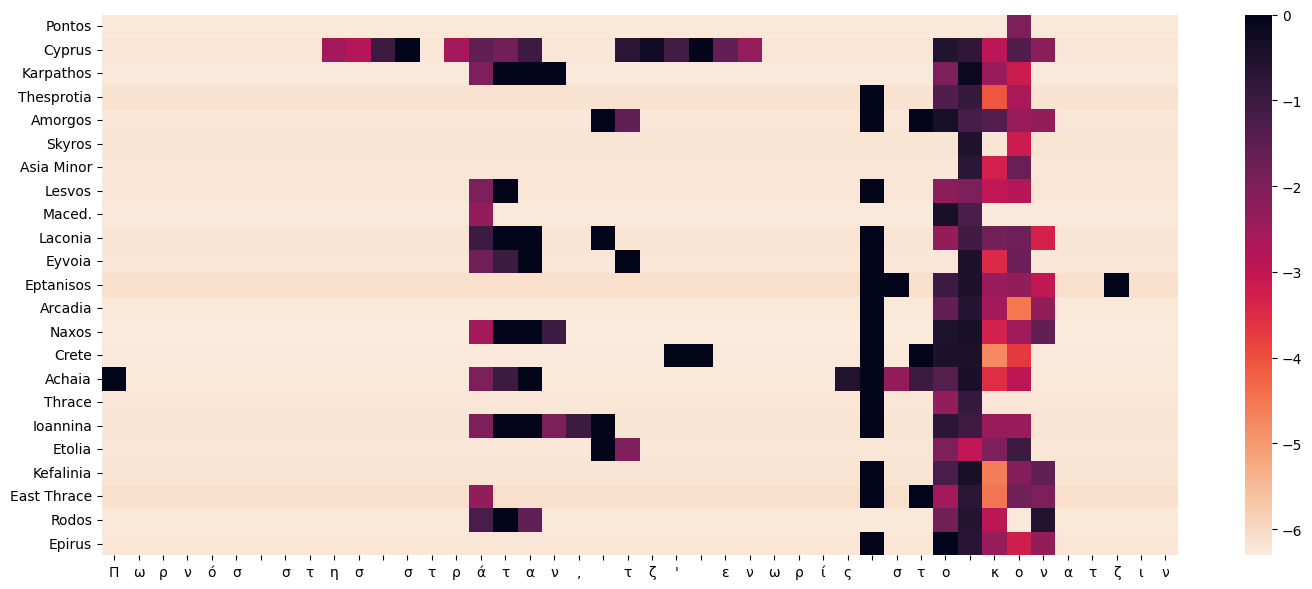

In [38]:
t = test[test.area=="Κύπρος"].sample().iloc[0]
df, ax = heatmap(t.text, models)
print(f'{t.text} ({t.area})', end=' -- ')
print(f'predicted as: {df.columns[df.mean(0).argmax()]}')
ax.figure.tight_layout(); ax.figure.savefig("heatmap.pdf", format="PDF", dpi=300)

* Evaluating on unseen proverbs

In [42]:
predictions = test.text.apply(lambda x: ling_dist(x, models=models)[0])
gold = test.area.apply(lambda x: loc_name[x]).values
print(classification_report(gold, predictions, zero_division=0))

              precision    recall  f1-score   support

      Achaia       0.14      0.12      0.13        32
     Amorgos       0.19      0.14      0.16        22
     Arcadia       0.08      0.06      0.07        31
  Asia Minor       0.17      0.17      0.17        18
       Crete       0.23      0.23      0.23        30
      Cyprus       0.73      0.79      0.76        24
 East Thrace       0.12      0.17      0.14        24
      Epirus       0.11      0.13      0.12        23
   Eptanisos       0.25      0.35      0.29        23
      Etolia       0.40      0.33      0.36        24
      Eyvoia       0.07      0.15      0.10        20
    Ioannina       0.17      0.14      0.15        29
   Karpathos       0.37      0.25      0.30        28
   Kefalinia       0.11      0.15      0.13        27
     Laconia       0.04      0.04      0.04        27
      Lesvos       0.45      0.38      0.41        24
      Maced.       0.19      0.19      0.19        27
       Naxos       0.34    

* The confusion matrix can inform us about the confusion in the predictions

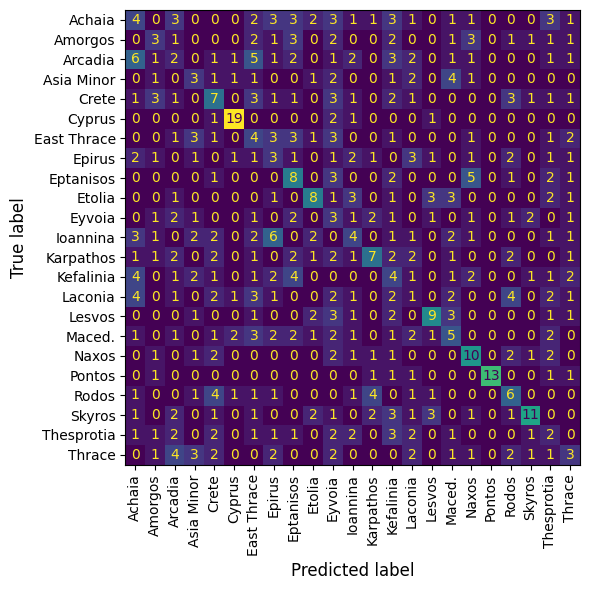

In [44]:
plt.rcParams["figure.figsize"] = (6,6); plt.rcParams["axes.labelsize"] = 12;
cm = ConfusionMatrixDisplay.from_predictions(gold, predictions, xticks_rotation='vertical', colorbar=False);
cm.figure_.tight_layout(); cm.figure_.savefig('authorship_confusion.pdf', format="PDF", dpi=300)

* Benchmarking standard text classifiers, on top of chanracter n-grams

In [ ]:
vect = TfidfVectorizer(ngram_range=(2,5), # token sequences
                       analyzer="char", # tokens are characters
                       max_df=0.5, # ignore tokens present in more than 50% of the texts
                       min_df=2, # ignore tokens not present in at least two documents 
                       lowercase=True)
vect.fit(train.text.values)
rep_t = vect.transform(['παροιμία'])
for i, feat in enumerate(rep_t.toarray()[0]):
    if feat>0:
        print(f'n-gram: "{vect.get_feature_names_out()[i]}" \t(tfidf: {feat:.2f})')

n-gram: "ία" 	(tfidf: 0.21)
n-gram: "αρ" 	(tfidf: 0.12)
n-gram: "αρο" 	(tfidf: 0.21)
n-gram: "αροι" 	(tfidf: 0.37)
n-gram: "ιμ" 	(tfidf: 0.19)
n-gram: "ιμί" 	(tfidf: 0.33)
n-gram: "ιμία" 	(tfidf: 0.38)
n-gram: "μί" 	(tfidf: 0.21)
n-gram: "μία" 	(tfidf: 0.30)
n-gram: "οι" 	(tfidf: 0.13)
n-gram: "οιμ" 	(tfidf: 0.28)
n-gram: "πα" 	(tfidf: 0.11)
n-gram: "παρ" 	(tfidf: 0.18)
n-gram: "παρο" 	(tfidf: 0.36)
n-gram: "ρο" 	(tfidf: 0.12)
n-gram: "ροι" 	(tfidf: 0.26)


In [ ]:
# benchmarking text classification algorithms
def benchmark_clf(train, dev):
    for algo_name, algorithm in (('SVM', LinearSVC), 
                                 ('Forest', RandomForestClassifier), 
                                 ('LR', LogisticRegression)):
        locator = Pipeline([('vect', vect), ('clf', algorithm())]) 
        locator.fit(train.text.values, train.area.values) 
        txt_preds = locator.predict(dev.text.values) 
        print(f'{algo_name}: {accuracy_score(dev.area.values, txt_preds):.3f}') # <- accuracy is fine for balanced data

benchmark_clf(train, dev)

SVM: 0.287
Forest: 0.231
LR: 0.278


In [ ]:
# inference on test data:
predictor_clf = Pipeline([('vect', vect), ('clf', LinearSVC())]) 
predictor_clf.fit(train.text.values, train.area.values) 
predictions_clf = predictor_clf.predict(test.text.values) 
print(classification_report(test.area.values, predictions_clf))

                 precision    recall  f1-score   support

        Ήπειρος       0.09      0.09      0.09        23
        Αιτωλία       0.42      0.46      0.44        24
        Αμοργός       0.26      0.32      0.29        22
Ανατολική Θράκη       0.19      0.25      0.22        24
        Αρκαδία       0.11      0.10      0.10        31
          Αχαΐα       0.31      0.25      0.28        32
      Επτάνησος       0.47      0.70      0.56        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.11      0.09      0.10        22
          Θράκη       0.26      0.20      0.23        25
       Ιωάννινα       0.26      0.17      0.21        29
       Κάρπαθος       0.42      0.39      0.41        28
     Κεφαλληνία       0.25      0.22      0.24        27
          Κρήτη       0.36      0.33      0.34        30
         Κύπρος       0.70      0.96      0.81        24
         Λέσβος       0.45      0.54      0.49        24
        Λακωνία       0.10    

## Predicting the location of proverbs
* Focusing on ones which are shared in multiple locations

In [ ]:
duplicates = pd.read_pickle('https://github.com/ipavlopoulos/paremia/raw/main/input/duplicates_geolocated.csv')

In [ ]:
# showing cases when only two candidate area exist and the model said one 
duplicates.insert(4, "prediction", predictor_clf.predict(duplicates.index.values))
duplicate_dilemma = duplicates.apply(lambda row: (row.area_num==2)&(row.prediction in row.area), 1)
duplicates[duplicate_dilemma].sort_values(by="place_num").head(5)

,place,place_num,area,area_num,prediction,latlon
text,,,,,,
(Ε)πήρε βάγια,"{Ήπειρος, Λακωνία}",2,"{Ήπειρος, Λακωνία}",2,Ήπειρος,"[(37.9982534, 23.7378671), (36.76027945, 22.79..."
Ξένοι πόνοι ξένα γέλια,"{Ρόδος, Κάλυμνος}",2,"{Ρόδος, Κάλυμνος}",2,Ρόδος,"[(37.00262545, 26.992424179156217), (36.172629..."
Νιός ήμουν και γέρασα,"{Μικρά Ασία, Βουρλά, Αμοργός}",2,"{Μικρά Ασία, Αμοργός}",2,Μικρά Ασία,"[(38.1846366, 23.5122768), (36.85252415, 25.89..."
Νηστικιά αρκούδα δε χορεύει,"{Μικρά Ασία, Κυδωνία, Κεφαλληνία, Ομαλά}",2,"{Μικρά Ασία, Κεφαλληνία}",2,Κεφαλληνία,"[(38.2379344, 20.560883), (38.1846366, 23.5122..."
"Νηστεύει ο δούλος του Θεού, γιατί ψωμί δεν έχει!","{Ήπειρος, Αχαΐα, Πάτρα}",2,"{Αχαΐα, Ήπειρος}",2,Αχαΐα,"[(37.9982534, 23.7378671), (38.0692748, 21.872..."


* Showing on ones our classifier said Cyrpus

In [ ]:
is_it_cyprus = duplicates.apply(lambda row: (row.prediction=='Κύπρος')&(row.prediction in row.area), 1)
duplicates[is_it_cyprus]

,place,place_num,area,area_num,prediction,latlon
text,,,,,,
Του κλέφτη κλέφτεις του;,"{Κύπρος, Λακωνία, Κύπρος, Κυθραία}",3,"{Κύπρος, Λακωνία}",2,Κύπρος,"[(36.76027945, 22.79046431389755), (34.9823018..."


## Regression on the coordinates
* Instead of classifying, predicting the geographical coordinates.
* Linear regression provides feature importance, i.e., terms that distinguish spatially, from South to North, from West to East. 

In [ ]:
vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, min_df=10, lowercase=True)
linear = Pipeline([('vect', vect), ('reg', LinearRegression())])
linear.fit(train.text.values, train[["lat", "lon"]].values)
txt_preds = linear.predict(test.text.values)

In [ ]:
print(f'R2 (train): {linear.score(train.text, train[["lat", "lon"]].values):.3f}')
print(f'R2 (dev): {linear.score(dev.text, dev[["lat", "lon"]].values):.3f}')

R2 (train): 0.265
R2 (dev): 0.147


In [ ]:
predicted_coords = linear.predict(test.text.values)
print(f"MAE of lat and lon: {mean_absolute_error(test.lat.values, predicted_coords[:, 0]):.2f} & {mean_absolute_error(test.lon.values, predicted_coords[:, 1]):.2f}")
print(f"MSE of lat and lon: {mean_squared_error(test.lat.values, predicted_coords[:, 0]):.2f} & {mean_squared_error(test.lon.values, predicted_coords[:, 1]):.2f}")

MAE of lat and lon: 1.31 & 1.82
MSE of lat and lon: 2.70 & 5.57


* Finding terms pushing North, South, West, and East

In [ ]:
importance_pd = pd.DataFrame({"feature":linear["vect"].get_feature_names_out(), 
                              "lat": linear["reg"].coef_[0, :],
                              "lon": linear["reg"].coef_[1, :]})

### Words pushing $\uparrow$ North: higher lat

In [ ]:
importance_pd.sort_values(by="lat", ascending=False).head(5)

,feature,lat,lon
692,τρώγει,3.635893,-0.032554
601,σάββας,3.161248,1.184160
195,διάβολο,2.948188,1.232402
552,πε,2.770396,1.545323
325,κε,2.755402,-0.781987


### Words pushing $\downarrow$ South: lower lat

In [ ]:
importance_pd.sort_values(by="lat", ascending=True).head(5)

,feature,lat,lon
660,τζ,-4.194842,11.198418
661,τζαί,-4.178670,11.034529
662,τζαι,-4.120807,10.672089
226,εγιώ,-3.835542,5.002954
664,τζι,-3.824136,10.232078


### Words pushing $\rightarrow$ East: higher lon

In [ ]:
importance_pd.sort_values(by="lon", ascending=False).head(5)

,feature,lat,lon
660,τζ,-4.194842,11.198418
661,τζαί,-4.178670,11.034529
662,τζαι,-4.120807,10.672089
664,τζι,-3.824136,10.232078
233,εμ,-2.805806,7.284577


### Words pushing $\leftarrow$ West: higher lon

In [ ]:
importance_pd.sort_values(by="lon", ascending=True).head(5)

,feature,lat,lon
115,βαρβάρα,-1.411852,-4.574122
702,τσου,0.507616,-4.082944
157,γελάει,-0.226152,-4.005389
466,ναν,0.649680,-3.835402
107,αφέντη,0.441481,-3.485066
